In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('private_banks.csv', index_col=['date'])
prices.head(10)

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
03-01-2018   926.325012    315.000000   1000.099976   560.450012   
04-01-2018   929.950012    314.700012   1000.400024   559.900024   
05-01-2018   931.799988    312.899994   1003.049988   563.250000   
08-01-2018   930.299988    314.149994   1006.099976   565.450012   
09-01-2018   931.849976    312.600006   1009.750000   565.299988   
10-01-2018   932.099976    312.000000   1002.250000   562.799988   
11-01-2018   936.275024    309.500000   1017.650024   558.750000   
12-01-2018   932.650024    317.700012   1023.349976   555.099976   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
03-01-2018    1630.250000     107.699997      54.150002  162.181824   
04-01-2018    1646.599976     108.650002      54.549999  160.636368   
05-01-2018    1698.199951     112.099998      58.250000  160.000000   
08-01-2018    1719.900024     115.550003      63.349998  159.681824   
09-01-2018    1725.050049     115.150002      62.799999  158.909088   
10-01-2018    1734.099976     113.150002      63.250000  159.318176   
11-01-2018    1700.300049     114.000000      68.550003  159.045456   
12-01-2018    1705.250000     115.050003      67.500000  158.863632   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
03-01-2018  514.900024  
04-01-2018  517.400024  
05-01-2018  539.700012  
08-01-2018  545.450012  
09-01-2018  538.900024  
10-01-2018  529.500000  
11-01-2018  533.599976  
12-01-2018  530.750000

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
30-12-2020  1432.500000    528.750000   2017.949951   625.099976   
31-12-2020  1436.300049    535.049988   1995.599976   620.450012   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
30-12-2020     899.049988      67.250000      36.650002  178.100006   
31-12-2020     894.950012      66.699997      37.049999  180.100006   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
30-12-2020  232.500000  
31-12-2020  231.050003

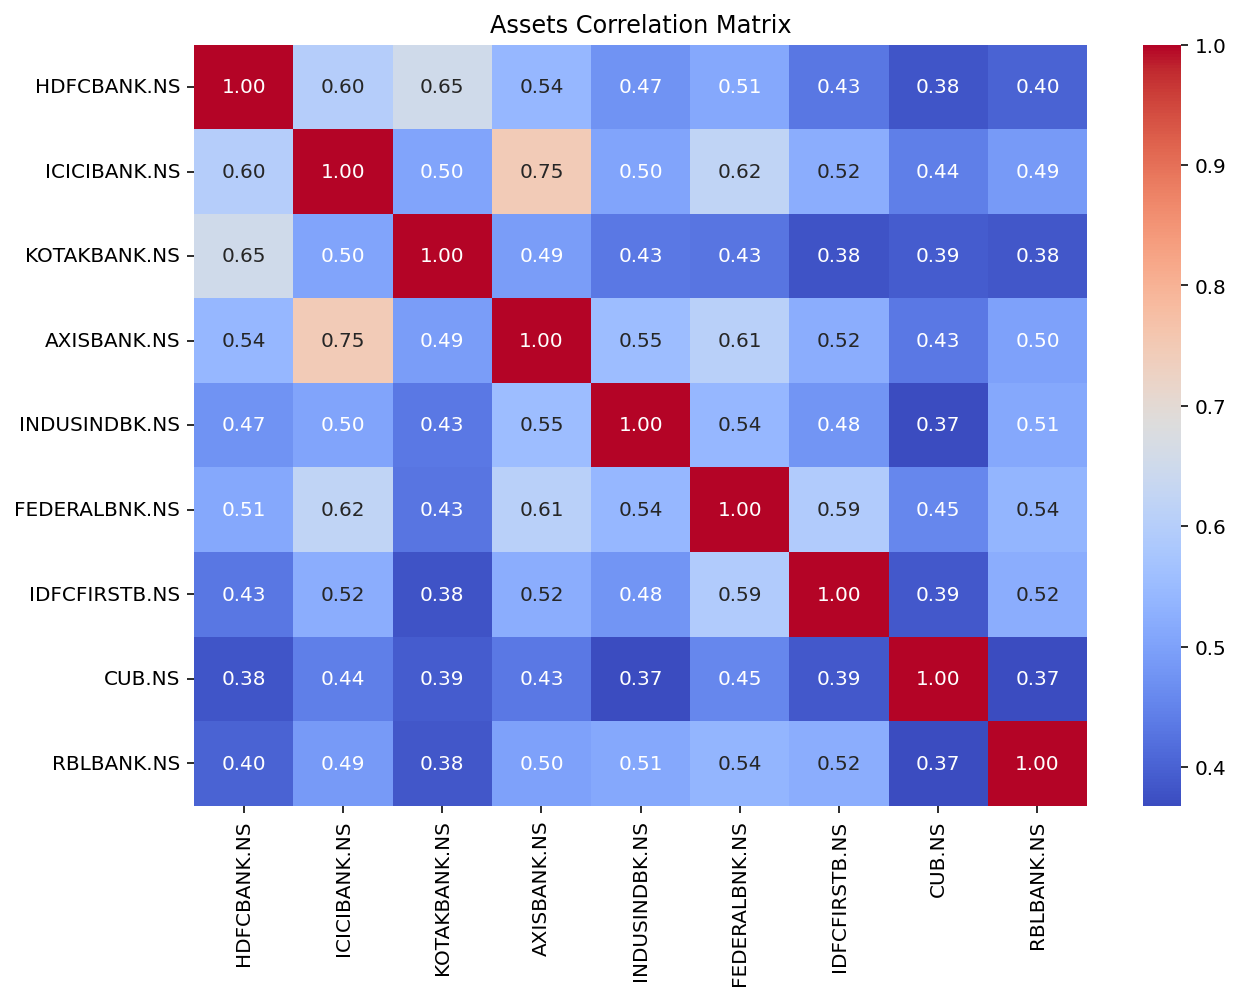

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDFCBANK.NS', 'KOTAKBANK.NS'), ('AXISBANK.NS', 'CUB.NS'), ('FEDERALBNK.NS', 'IDFCFIRSTB.NS')]


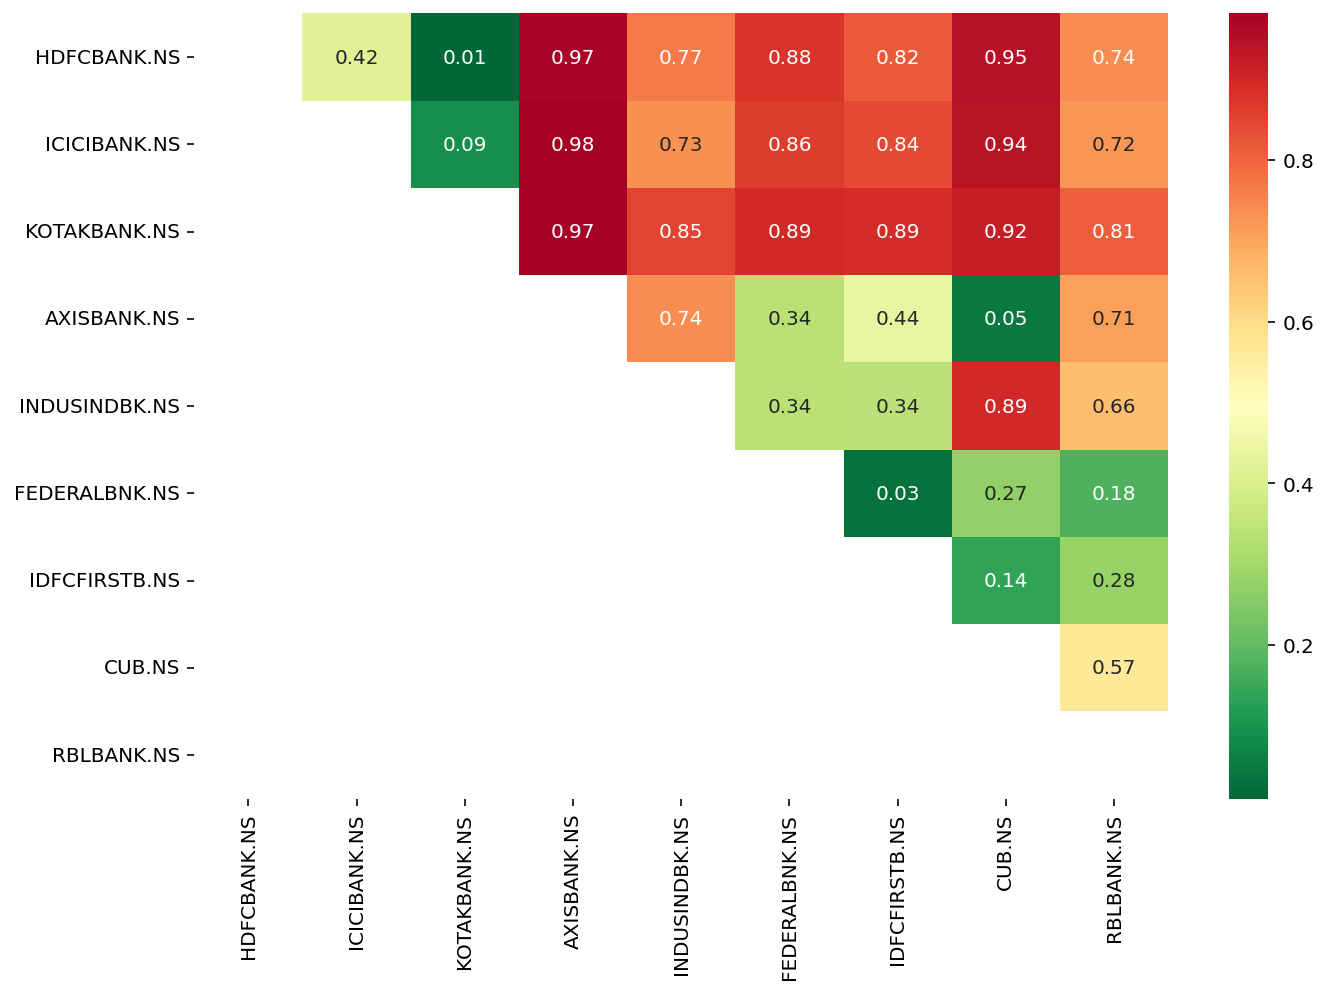

In [8]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
# ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [9]:
# final pair to test strategy
asset1 = 'INDUSINDBK.NS'
asset2 = 'IDFCFIRSTB.NS'

In [10]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

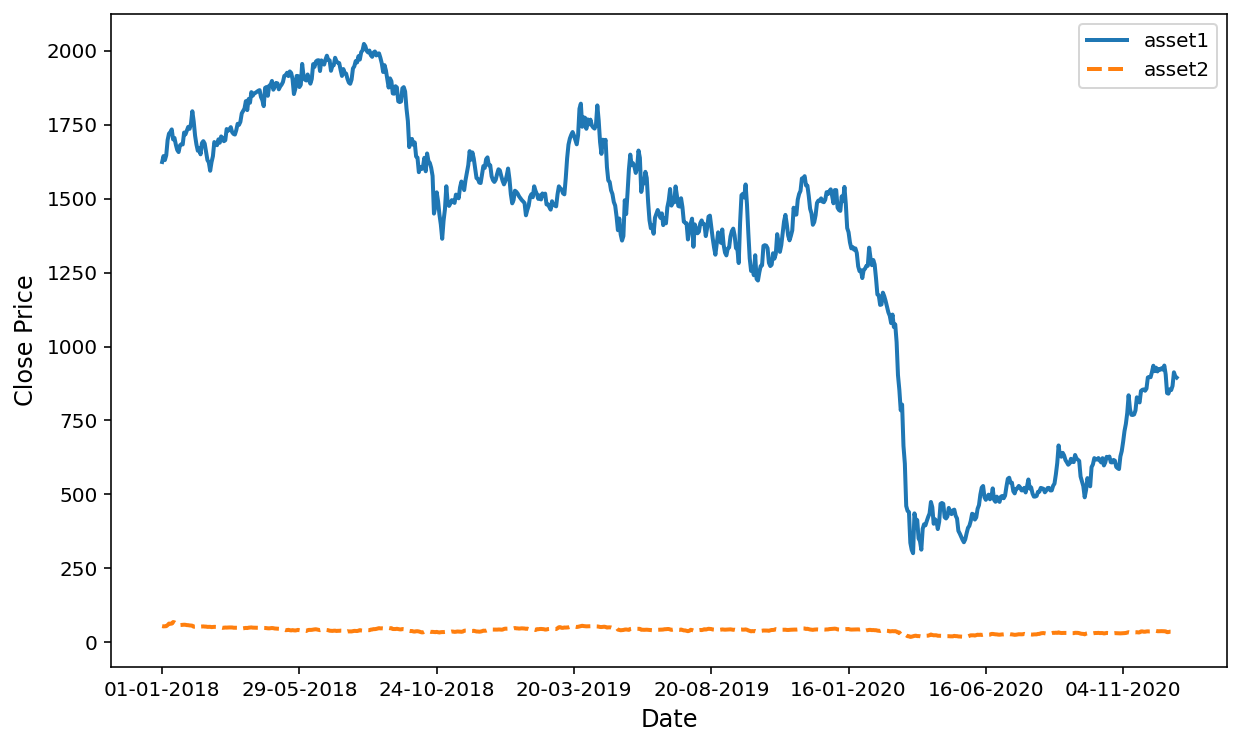

In [12]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500)  

In [13]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                          1.479e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        17:00:11   Log-Likelihood:                         -2669.9
No. Observations:                 740   AIC:                                      5342.
Df Residuals:                     739   BIC:                                      5346.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.0284      0.000    121.621      0.000       0.028       0.029
==============================================================================
Omnibus:                       42.723   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.515
Skew:                          -0.530   Prob(JB):                     9.66e-10
Kurtosis:                       2.526   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

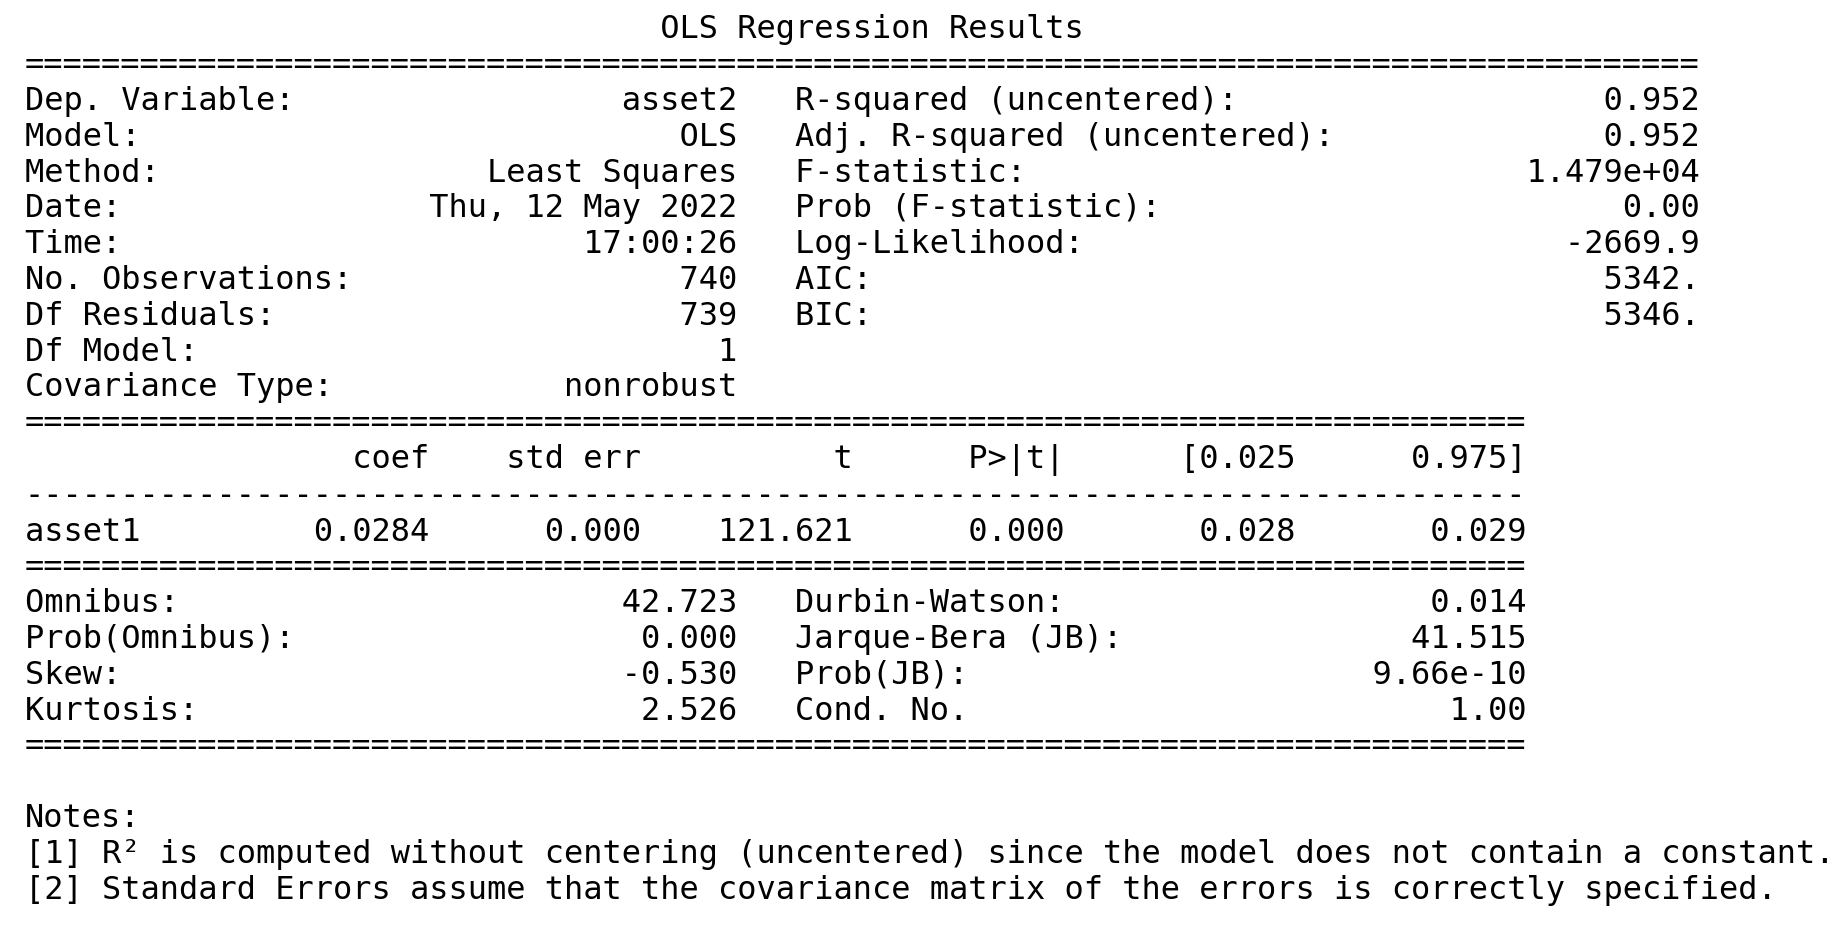

In [15]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [16]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.02835145488654328


In [18]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

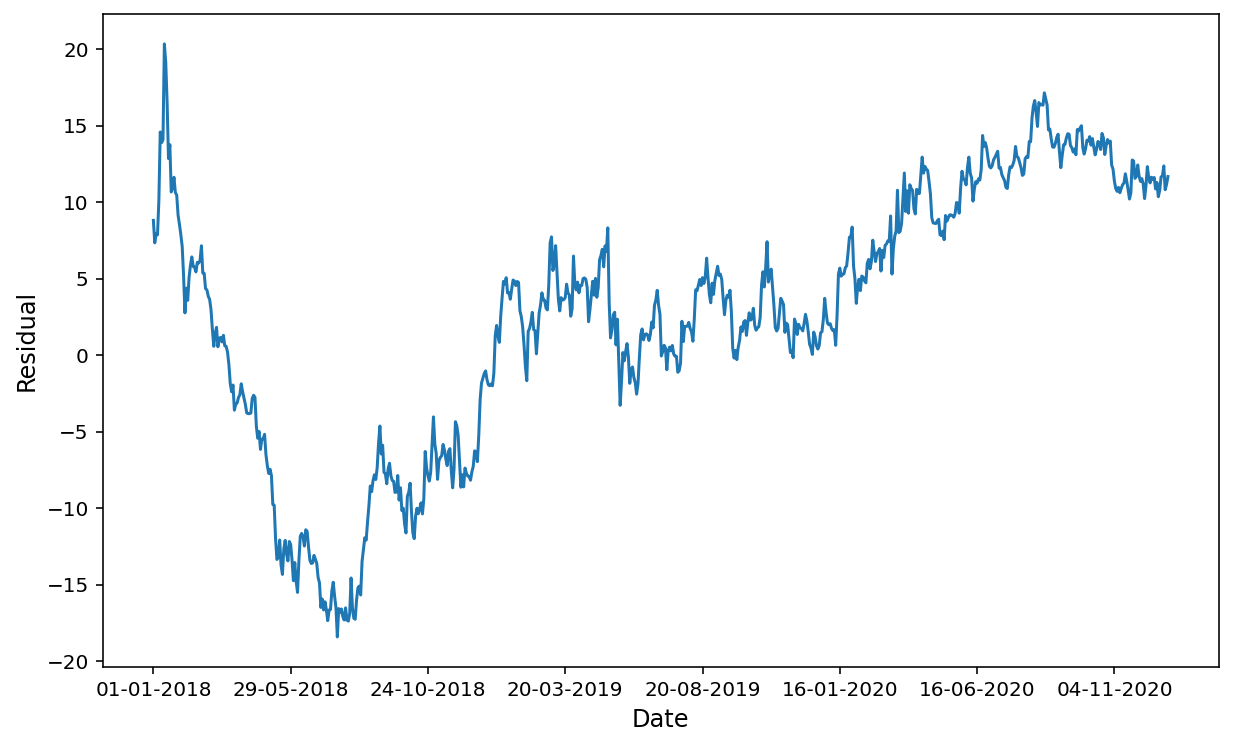

In [20]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [21]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(residual, maxlag = 1)
adf

(-1.5718610916835227,
 0.49771135628882396,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 2160.1759222560704)

In [22]:
print('Critical Value = ', adf[0])

Critical Value =  -1.5718610916835227


In [23]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [24]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [25]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [26]:
signals.head()

asset1     asset2
date                             
01-01-2021  900.150024  37.400002
04-01-2021  897.849976  38.599998
05-01-2021  921.650024  39.700001
06-01-2021  922.349976  41.400002
07-01-2021  952.049988  45.799999

In [27]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [28]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                     
01-01-2021  900.150024  37.400002  1.730688            1.0           -1.0
04-01-2021  897.849976  38.599998  1.424020            1.0           -1.0
05-01-2021  921.650024  39.700001  1.406938            1.0           -1.0
06-01-2021  922.349976  41.400002  1.051464            1.0           -1.0
07-01-2021  952.049988  45.799999  0.485116            1.0           -1.0

In [29]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [30]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

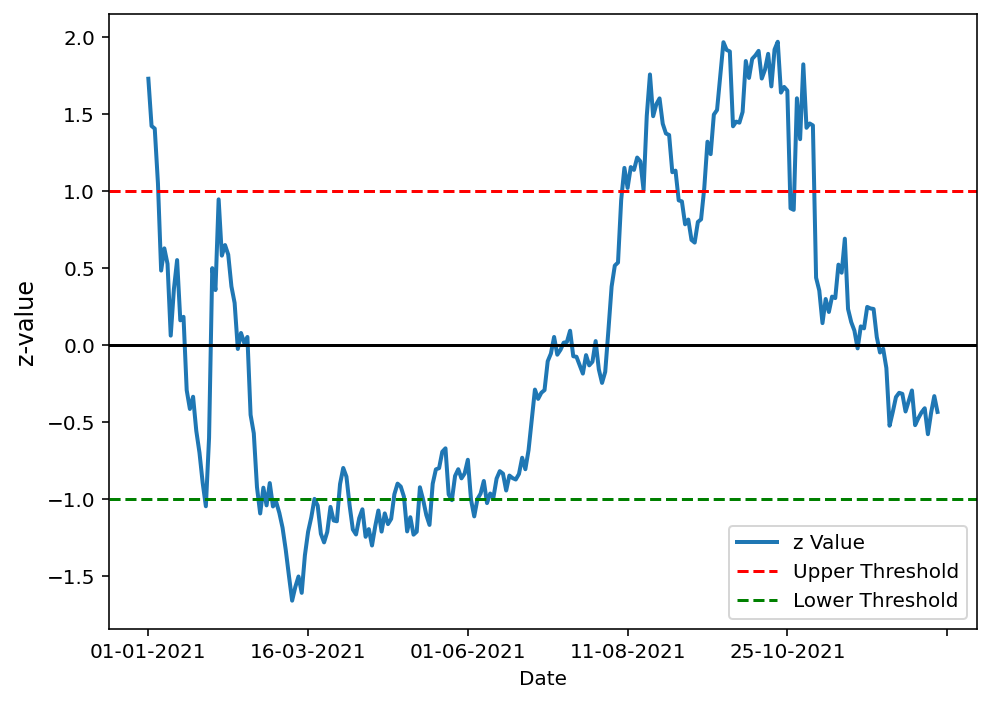

In [33]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 5), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [34]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  900.150024  37.400002  1.730688            1.0           -1.0   
04-01-2021  897.849976  38.599998  1.424020            1.0           -1.0   
05-01-2021  921.650024  39.700001  1.406938            1.0           -1.0   
29-12-2021  870.000000  47.400002 -0.438392            1.0           -1.0   
30-12-2021  885.400024  47.500000 -0.329983            1.0           -1.0   
31-12-2021  888.150024  48.349998 -0.432791            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [35]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021   900.150024  37.400002  1.730688            1.0           -1.0   
04-01-2021   897.849976  38.599998  1.424020            1.0           -1.0   
05-01-2021   921.650024  39.700001  1.406938            1.0           -1.0   
06-01-2021   922.349976  41.400002  1.051464            1.0           -1.0   
28-01-2021   802.599976  47.900002 -1.045294            1.0           -1.0   
22-02-2021  1022.900024  61.500000 -1.092071            1.0           -1.0   
24-02-2021  1070.000000  63.799999 -1.039440            1.0           -1.0   
26-02-2021  1062.949951  63.450001 -1.046501            1.0           -1.0   
01-03-2021  1067.949951  63.450001 -1.016586            1.0           -1.0   
02-03-2021  1073.349976  64.500000 -1.088820            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
28-01-2021         1         1.0        -1        -1.0  
22-02-2021         1         1.0        -1        -1.0  
24-02-2021         1         1.0        -1        -1.0  
26-02-2021         1         1.0        -1        -1.0  
01-03-2021         1         0.0        -1         0.0  
02-03-2021         1         0.0        -1         0.0

In [36]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021   900.150024  37.400002  1.730688            1.0           -1.0   
07-01-2021   952.049988  45.799999  0.485116            1.0           -1.0   
28-01-2021   802.599976  47.900002 -1.045294            1.0           -1.0   
29-01-2021   846.099976  47.200001 -0.601093            1.0           -1.0   
22-02-2021  1022.900024  61.500000 -1.092071            1.0           -1.0   
03-09-2021  1003.750000  45.650002  0.940981            1.0           -1.0   
16-09-2021  1130.949951  50.950001  1.020437            1.0           -1.0   
26-10-2021  1154.900024  52.849998  0.889528            1.0           -1.0   
28-10-2021  1176.000000  49.549999  1.603673            1.0           -1.0   
08-11-2021  1061.150024  51.349998  0.438774            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
07-01-2021         0         1.0         0        -1.0  
28-01-2021         1         1.0        -1        -1.0  
29-01-2021         0        -1.0         0         1.0  
22-02-2021         1         1.0        -1        -1.0  
03-09-2021         0         1.0         0        -1.0  
16-09-2021        -1        -1.0         1         1.0  
26-10-2021         0         1.0         0        -1.0  
28-10-2021        -1        -1.0         1         1.0  
08-11-2021         0         1.0         0        -1.0

In [37]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

952.049988     1
802.599976     1
1022.900024    1
1070.000000    1
1062.949951    1
1011.900024    1
927.250000     1
910.150024     1
948.849976     1
993.900024     1
1028.000000    1
1003.549988    1
1003.750000    1
1154.900024    1
1061.150024    1
Name: asset1, dtype: int64

In [38]:
signals

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  900.150024  37.400002  1.730688            1.0           -1.0   
04-01-2021  897.849976  38.599998  1.424020            1.0           -1.0   
05-01-2021  921.650024  39.700001  1.406938            1.0           -1.0   
06-01-2021  922.349976  41.400002  1.051464            1.0           -1.0   
07-01-2021  952.049988  45.799999  0.485116            1.0           -1.0   
...                ...        ...       ...            ...            ...   
27-12-2021  855.250000  46.400002 -0.408902            1.0           -1.0   
28-12-2021  852.650024  47.400002 -0.577348            1.0           -1.0   
29-12-2021  870.000000  47.400002 -0.438392            1.0           -1.0   
30-12-2021  885.400024  47.500000 -0.329983            1.0           -1.0   
31-12-2021  888.150024  48.349998 -0.432791            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021         0         1.0         0        -1.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [39]:
signals = signals.reset_index()

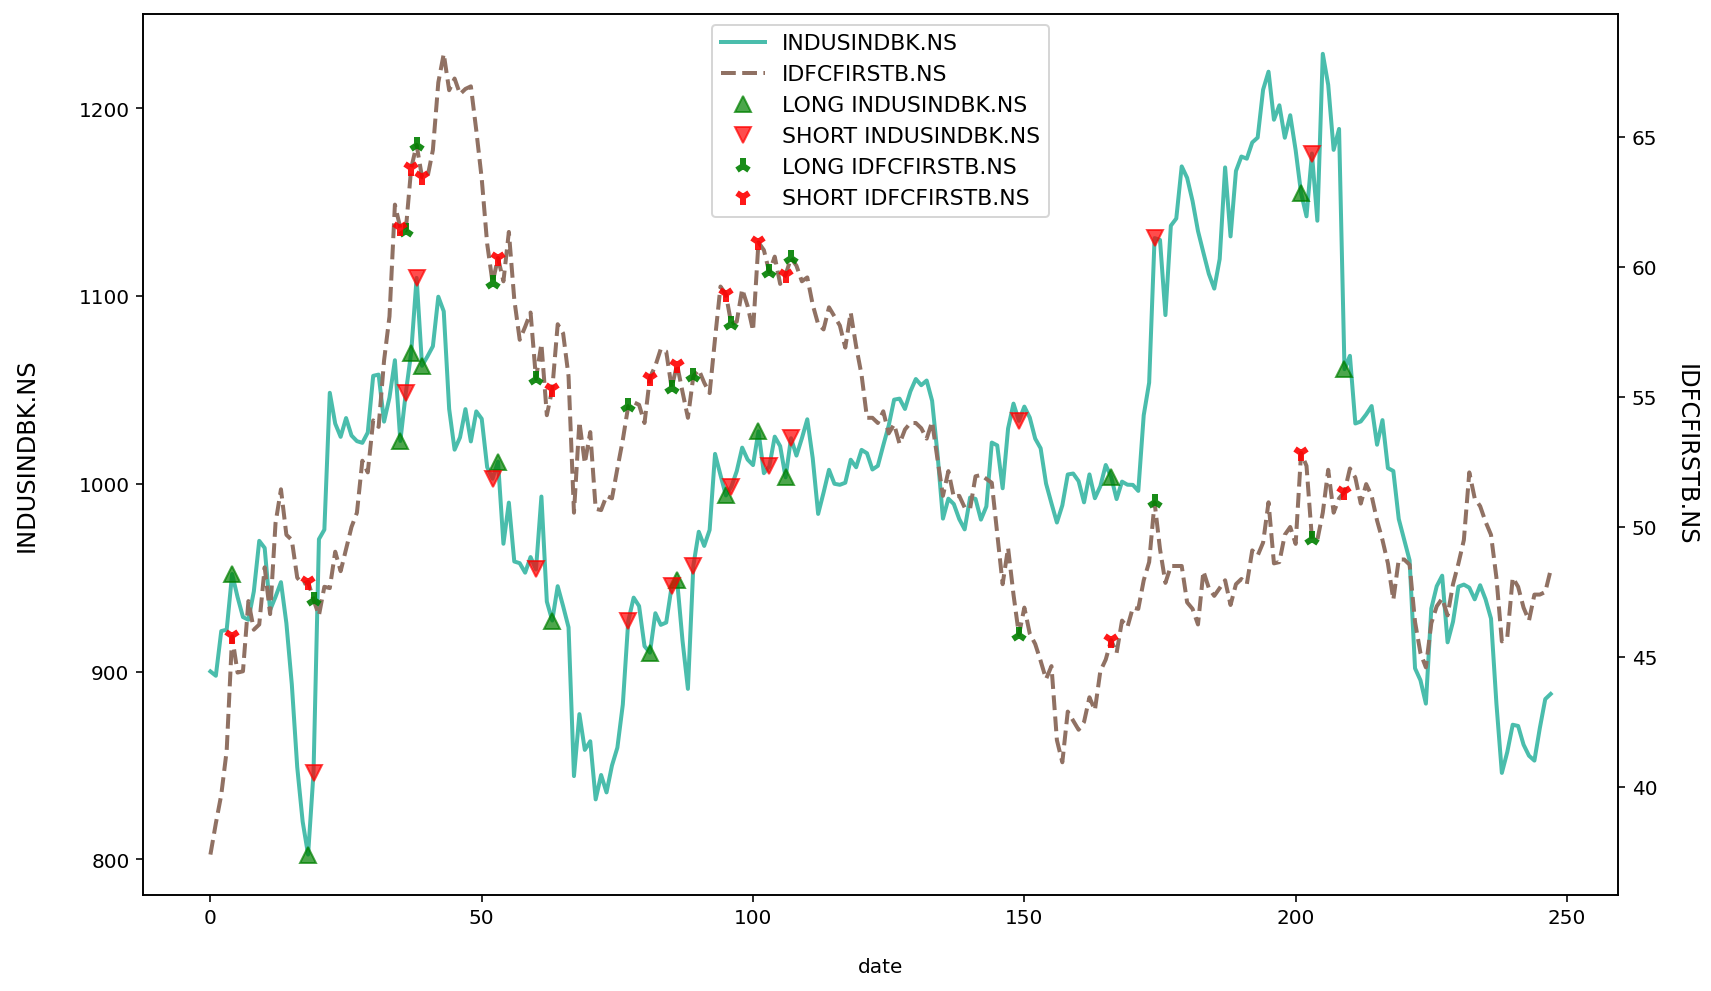

In [44]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,7))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='upper center', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [45]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [46]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [47]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    900.150024           NaN            NaN            NaN       NaN   
1    897.849976      0.000000  100000.000000  100000.000000       NaN   
2    921.650024      0.000000  100000.000000  100000.000000  0.000000   
3    922.349976      0.000000  100000.000000  100000.000000  0.000000   
4    952.049988  77116.049012   22883.950988  100000.000000  0.000000   
243  855.250000  69275.250000   35920.897262  105196.147262 -0.004522   
244  852.650024  69064.651976   35920.897262  104985.549239 -0.002002   
245  870.000000  70470.000000   35920.897262  106390.897262  0.013386   
246  885.400024  71717.401976   35920.897262  107638.299239  0.011725   
247  888.150024  71940.151976   35920.897262  107861.049239  0.002069   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           1.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [48]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0    900.150024            NaN           NaN            NaN       NaN   
4    952.049988   77116.049012  22883.950988  100000.000000  0.000000   
18   802.599976  130021.196047 -42126.647035   87894.549012 -0.015916   
19   846.099976   68534.098024  26407.450988   94941.549012  0.080176   
35  1022.900024  165709.803888 -56447.450956  109262.352932 -0.030893   

    positions1  
0          NaN  
4          1.0  
18         1.0  
19        -1.0  
35         1.0

In [49]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [50]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    900.150024           NaN            NaN            NaN       NaN   
1    897.849976      0.000000  100000.000000  100000.000000       NaN   
2    921.650024      0.000000  100000.000000  100000.000000  0.000000   
3    922.349976      0.000000  100000.000000  100000.000000  0.000000   
4    952.049988  77116.049012   22883.950988  100000.000000  0.000000   
243  855.250000  69275.250000   35920.897262  105196.147262 -0.004522   
244  852.650024  69064.651976   35920.897262  104985.549239 -0.002002   
245  870.000000  70470.000000   35920.897262  106390.897262  0.013386   
246  885.400024  71717.401976   35920.897262  107638.299239  0.011725   
247  888.150024  71940.151976   35920.897262  107861.049239  0.002069   

     positions1     asset2     holdings2          cash2   total asset2  \
0           NaN  37.400002           NaN            NaN            NaN   
1           0.0  38.599998      0.000000  100000.000000  100000.000000   
2           0.0  39.700001      0.000000  100000.000000  100000.000000   
3           0.0  41.400002      0.000000  100000.000000  100000.000000   
4           1.0  45.799999 -67142.798886  167142.798886  100000.000000   
243         0.0  46.400002 -68022.402243  189499.304457  121476.902214   
244         0.0  47.400002 -69488.402243  189499.304457  120010.902214   
245         0.0  47.400002 -69488.402243  189499.304457  120010.902214   
246         0.0  47.500000 -69635.000000  189499.304457  119864.304457   
247         0.0  48.349998 -70881.097757  189499.304457  118618.206700   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000        -1.0  
243  0.006071         0.0  
244 -0.012068         0.0  
245  0.000000         0.0  
246 -0.001222         0.0  
247 -0.010396         0.0

In [51]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0    900.150024            NaN           NaN            NaN       NaN   
4    952.049988   77116.049012  22883.950988  100000.000000  0.000000   
18   802.599976  130021.196047 -42126.647035   87894.549012 -0.015916   
19   846.099976   68534.098024  26407.450988   94941.549012  0.080176   
35  1022.900024  165709.803888 -56447.450956  109262.352932 -0.030893   

    positions1     asset2      holdings2          cash2   total asset2  \
0          NaN  37.400002            NaN            NaN            NaN   
4          1.0  45.799999  -67142.798886  167142.798886  100000.000000   
18         1.0  47.900002 -140442.804486  237364.201129   96921.396643   
19        -1.0  47.200001  -69195.201114  168169.000015   98973.798900   
35         1.0  61.500000 -180318.000000  258328.000015   78010.000015   

     return2  positions2  
0        NaN         NaN  
4   0.000000        -1.0  
18 -0.001510        -1.0  
19  0.021176         1.0  
35  0.017204        -1.0

In [52]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

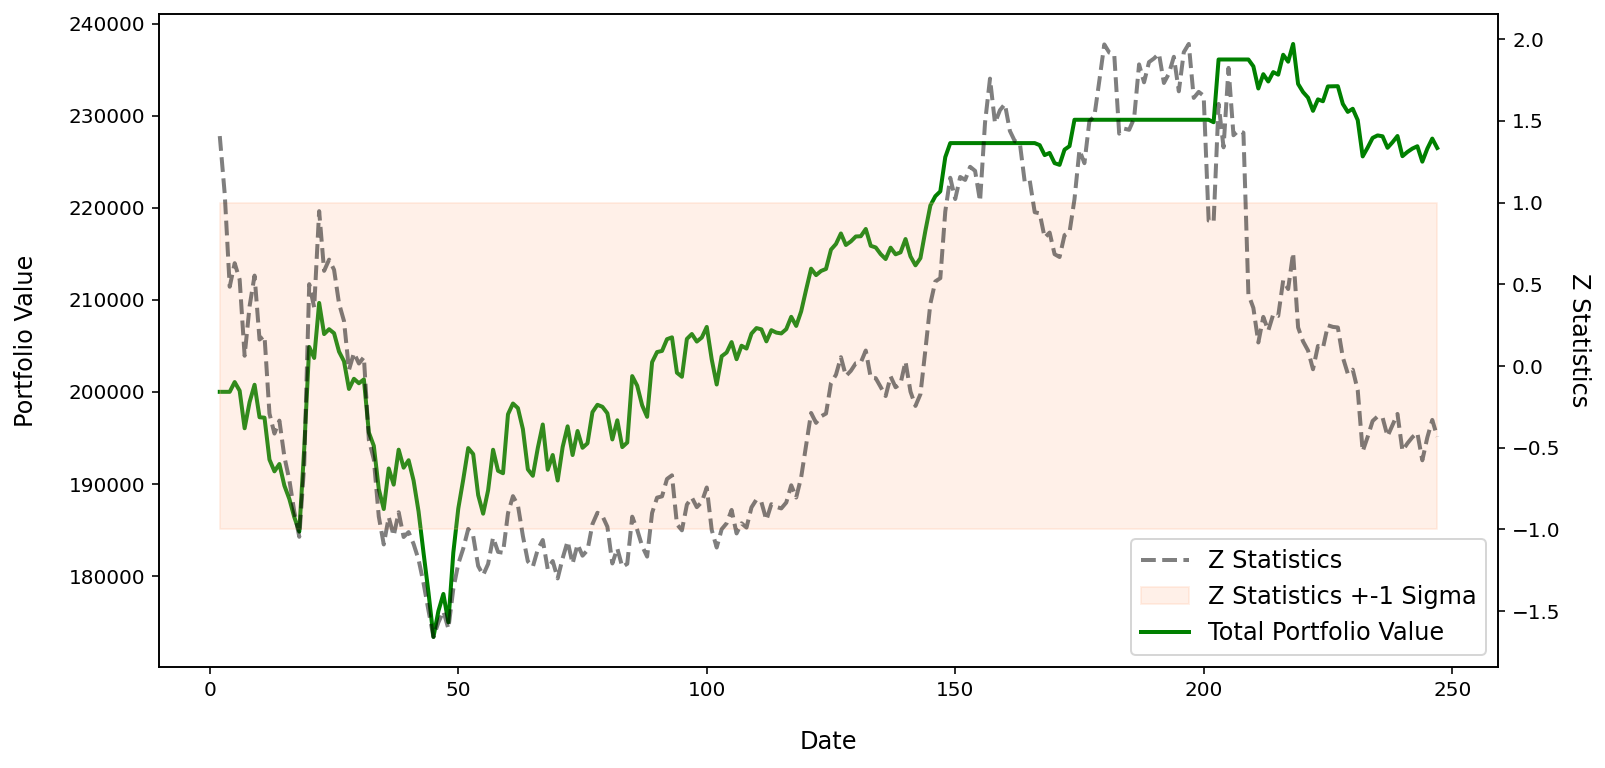

In [57]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='best', fontsize=12);
plt.savefig('chart8', dpi=500);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

226479.25593821998

In [48]:
profit = final_portfolio - 2*initial_capital
profit

26479.255938219983

In [49]:
roi = (profit/(2*initial_capital))*100
roi

13.239627969109991

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 238.002%
